In [1]:
import numpy as np
import pandas as pd
import os, cv2, glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
         
def split_data(images, labels):
    try:
        x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3)
        x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

        return x_train, y_train, x_val, y_val, x_test, y_test
    except ValueError as e:
        print(f"ValueError occurred during data splitting: {str(e)}")
        return None, None, None, None, None, None

In [3]:
images = []
labels = []
size = (128,128)


cat_folder = '/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/Cat/'
dog_folder = '/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages/Dog/'

def getData(folder, label):
    file_names = os.listdir(folder)

    for file_name in file_names:
        path = folder + file_name
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, dsize=size)
            images.append(img)
            labels.append(label)

getData(cat_folder, 0)
getData(dog_folder, 1)

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


In [4]:
images[0].shape

(128, 128)

In [5]:
images = np.array(images).reshape(-1,128,128, 1)
images = images/255

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(images, labels)

In [7]:
y_val = np.array(y_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [8]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, PReLU, ELU, UpSampling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, Callback
import keras.backend as K

model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(UpSampling2D())
model.add(Conv2D(filters=128, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=256, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=400, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation=ELU()))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(128, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(64, activation=ELU()))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

class CustomLossCallback(Callback):
    def __init__(self, threshold=0.5):
        super(CustomLossCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        
        if val_loss > self.threshold:
            penalty = 0.1  # You can adjust the penalty factor
            new_lr = K.get_value(self.model.optimizer.lr) * (1.0 - penalty)
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f'Applying penalty. New learning rate: {new_lr}')
        else:
            reward = 0.05  # You can adjust the reward factor
            new_lr = K.get_value(self.model.optimizer.lr) * (1.0 + reward)
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f'Rewarding. New learning rate: {new_lr}')

model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('latest_check.h5', save_best_only=True)
custom_loss_callback = CustomLossCallback(threshold=1.0)

history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, model_checkpoint, custom_loss_callback])

val_loss_values = history.history['val_loss']

last_val_loss = val_loss_values[-1]

lr_scheduler = LearningRateScheduler(lambda epoch, lr: custom_lr_schedule(epoch, lr, last_val_loss))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        280640    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 up_sampling2d (UpSampling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                        

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Applying penalty. New learning rate: 0.0009000000427477062
545/545 [==============================] - 61s 77ms/step - loss: 0.6496 - accuracy: 0.6313 - val_loss: 2.0410 - val_accuracy: 0.5004 - lr: 0.0010
Epoch 2/50
545/545 [==============================] - 39s 72ms/step - loss: 0.5313 - accuracy: 0.7360 - val_loss: 0.9214 - val_accuracy: 0.5344 - lr: 9.0000e-04
Epoch 3/50
545/545 [==============================] - 40s 73ms/step - loss: 0.4658 - accuracy: 0.7833 - val_loss: 0.6122 - val_accuracy: 0.6800 - lr: 9.4500e-04
Epoch 4/50
545/545 [==============================] - 40s 74ms/step - loss: 0.4159 - accuracy: 0.8121 - val_loss: 0.5508 - val_accuracy: 0.7602 - lr: 9.9225e-04
Epoch 5/50
545/545 [==============================] - 40s 74ms/step - loss: 0.3774 - accuracy: 0.8347 - val_loss: 0.4209 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 6/50
545/545 [==============================] - 40s 74ms/step - loss: 0.3348 - accuracy: 0.8543 - val_loss: 0.3943 - val_accuracy: 0.8191 - lr: 0.001

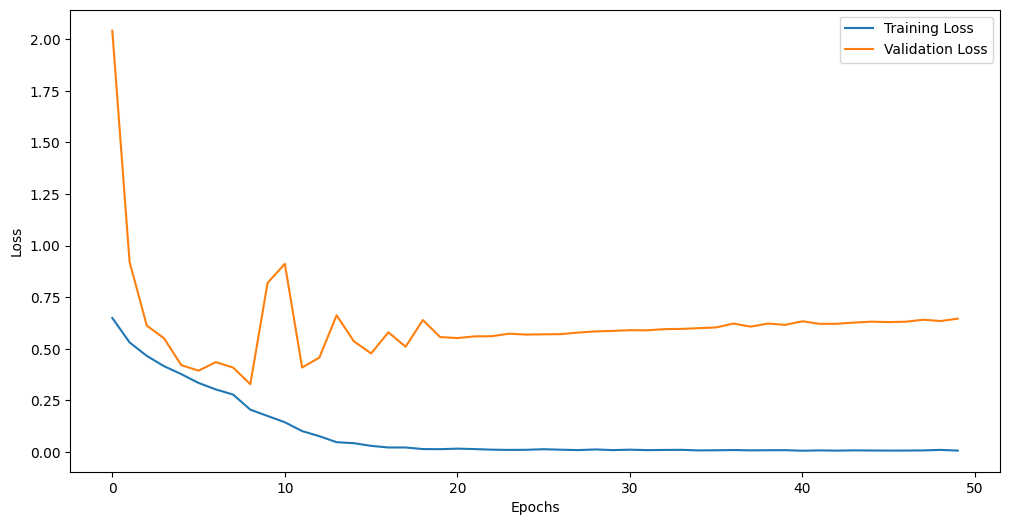

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

117/117 [==============================] - 3s 22ms/step


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error

# Accuracy
accuracy = accuracy_score(y_test,y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test,y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test,y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,y_pred_binary)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test,y_pred_binary)
auc = roc_auc_score(y_test,y_pred_binary)
print("AUC:", auc)

Accuracy: 0.8608509499598609
Precision: 0.8887621220764403
Recall: 0.8274030801911842
F1 Score: 0.856985698569857
Confusion Matrix:
 [[1659  195]
 [ 325 1558]]
AUC: 0.8611125433318381


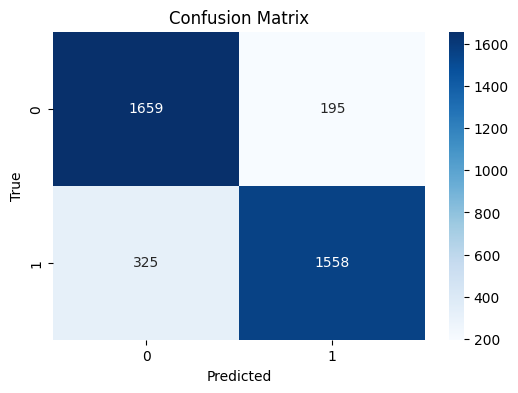

In [14]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

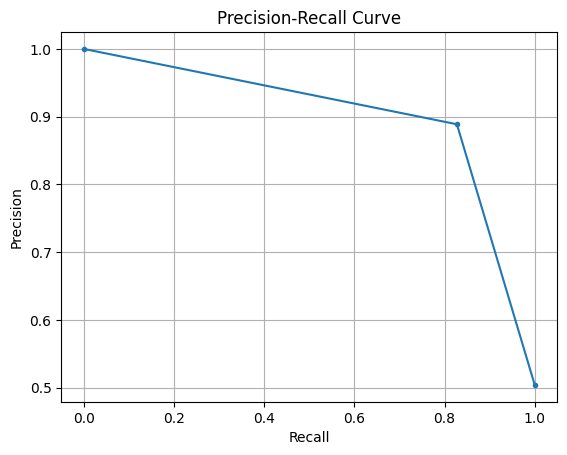

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_binary)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

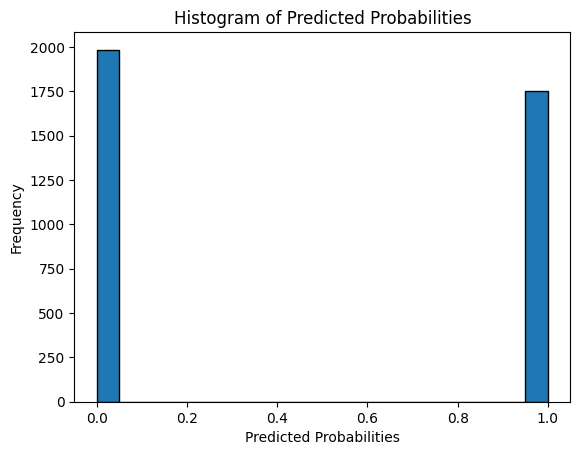

In [16]:
plt.hist(y_pred_binary, bins=20, edgecolor='k')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

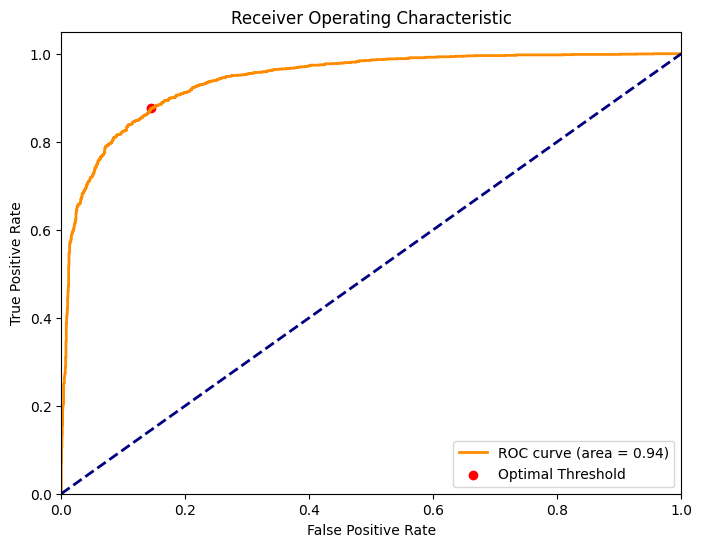

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='red', marker='o', label='Optimal Threshold')
plt.legend()

plt.show()

y_pred_binary = (y_pred >= optimal_threshold).astype(int)


In [18]:
model.save('/kaggle/working/Cat_vs_Dog_Arihant.keras')